### Define topology

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import random

from codes.utils import printoptions
from codes.graph_utils import Graph, spectral_gap

class Ring(Graph):
    def __init__(self, n):
        edges = [(i, i + 1) for i in range(n - 1)] + [(n - 1, 0)]
        super().__init__(n, edges)
        self.n = n
        metropolis = np.zeros((6, 6))
        for (i, j) in edges:
            metropolis[i][j]=0.33
            metropolis[j][i]=0.33
            metropolis[i][i]=0.33
        self.metropolis_weight=metropolis
        self.spectral_gap = spectral_gap(metropolis)

    def __str__(self):
        return f"Ring(n={self.n})"
    
    def get_neighbors_index(self, good_node, include_self):
        return [(good_node-1) % self.n, good_node, (good_node+1) % self.n] if include_self else [(good_node-1) % self.n, (good_node+1) % self.n]

    def get_neighbors_weight(self, good_node, include_self):
        indices = self.get_neighbors_index(good_node, include_self)
        weights = [self.metropolis_weight[good_node][j] for j in indices]
        return weights

    def get_good_neighbors_index(self, good_node, include_self):
        indices = self.get_neighbors_index(good_node, include_self)
        return [i for i in indices if i not in [0, 1]]

    def spectral_gap(self):
        print(self.metropolis_weight)
        eigenvalues = sorted(np.abs(np.linalg.eigvals(self.metropolis_weight)))
        sg = 1 - eigenvalues[-2]
        return sg


class DataManager(object):
    
    def __init__(self, data, graph, attacker):
        assert len(data) == 4

        self.good_data = data
        self.graph = graph
        self.attacker = attacker
        attacker.configure(self, graph)
    
    def getDataOn(self, good_node):
        data = [self.attacker(0), self.attacker(1)] + self.good_data
        indices = self.graph.get_neighbors_index(good_node, include_self=True)
        return [data[i] for i in indices]

    def setGoodData(self, data):
        self.good_data = data

    def get(self, good_node):
        return self.good_data[good_node - 2]

class Attack(object):

    def configure(self, data_manager, graph):
        self.data_manager = data_manager
        self.graph = graph
        self.n = graph.n

    def __call__(self, byzantine_node):
        pass


class RandomAttack(Attack):
    def __init__(self, a, b):
        self.a = a
        self.b = b
        
    def __call__(self, byzantine_node):
        if byzantine_node == 0 or byzantine_node == 1:
            return float(random.randint(self.a, self.b))
        
        
class ConstValueAttack(Attack):
    def __init__(self, v0, v1):
        self.v0 = v0
        self.v1 = v1

    def __call__(self, byzantine_node):
        if byzantine_node == 0:
            return self.v0
        if byzantine_node == 1:
            return self.v1
        raise NotImplementedError

class DissensusAttack(Attack):
    def __init__(self, eps):
        self.eps = eps

    def __call__(self, byzantine_node):
        data = self.data_manager.good_data        
        m = self.graph.metropolis_weight[2 if byzantine_node else self.n-1]
        if byzantine_node == 0:
            v = m[self.n-2] * (data[self.n-2 -2] - data[self.n-1 -2])
            v /= m[0]
            return data[self.n-1 -2] - self.eps * v

        if byzantine_node == 1:
            v = m[3] * (data[3 -2] - data[2 -2])
            v /= m[1]
            return data[2 -2] - self.eps * v 

        raise NotImplementedError


In [84]:
class Experiment(object):

    def __init__(self, data_manager, graph, n, b, p, T):
        # Number of workers
        self.n = n
        # Number of Byzantine workers
        self.b = b
        self.p = p
        self.T = T

        self.data_manager = data_manager
        self.graph = graph
        self.mu0 = sum(data_manager.good_data) / len(data_manager.good_data)

        self.consensus_distances = []
        self.errors = []

    def consensus_distance(self):
        data = self.data_manager.good_data
        mu = sum(data) / len(data)
        return sum((i - mu) ** 2 for i in data) / len(data)

    def error(self):
        data = self.data_manager.good_data
        return sum((i - self.mu0) ** 2 for i in data) / len(data)

    def run(self):
        self.consensus_distances.append(self.consensus_distance())
        self.errors.append(self.error())
        for t in range(self.T):
            new_data = []
            for i in range(self.b, self.n):
                # Aggregation on good worker i
                new_data.append(self.agg(i))

            self.data_manager.setGoodData(new_data)
            self.consensus_distances.append(self.consensus_distance())
            self.errors.append(self.error())

    def agg(self, i):
        raise NotImplementedError



# SSClip
def clip(v, tau):
    v_norm = abs(v)
    scale = min(1, tau / v_norm)
    return v * scale

class SSClip(Experiment):

    def agg(self, i):
        v = self.data_manager.get(i)

        delta_i = 0.33
        good_local_indices = self.graph.get_good_neighbors_index(i, include_self=False)

        tau = 0
        for j in good_local_indices:
            w = self.graph.metropolis_weight[i][j]
            d = self.data_manager.get(j)
            distance = (d - v) ** 2
            tau += w * distance
        
        if delta_i == 0:
            tau = np.inf
        else:
            tau /= delta_i
            tau = np.sqrt(tau)

        local_data = self.data_manager.getDataOn(i)
        weights = self.graph.get_neighbors_weight(i, include_self=True)
        new_data = 0
        a = []
        for index, vv, w in zip(self.graph.get_neighbors_index(i, include_self=True), local_data, weights):
            if vv == v:
                z = v
            else:
                z = v + clip(vv - v, tau)
            new_data += w * z
            a.append(f"Clip node {index} from {vv} to {z}")
        
        return new_data

Note that combining median/trimmed mean with mixing matrix is tricky because:

- If we ignore the mixing matrix, then they are robust to the dissensus attack.
- If we consider the mixing matrix, that is, duplicate values according to the mixing weight, then they are no longer cursed by heterogeneity. (This is however not the implementation of Bridge.)

In [85]:
N = 6
b = 2
data0 = [0, 0, 200, 200]

results = []
for attacker, attack_name in [(ConstValueAttack(0, 200), "constant"), (DissensusAttack(1), "dissensus"), (RandomAttack(-200,200), "random")]:
    Defense, defense_name = SSClip, "SSClip"
    try:
        graph = Ring(n=N)
        data_manager = DataManager(data0, graph, attacker)
        p = graph.spectral_gap**2
        runner = Defense(data_manager, graph, N, b, p, 100)
        runner.run()
        results.append({"exp": runner, "attack": attack_name, "p": p})
    except:
        pass


### Performance of aggregators under constant value attack

Note that this part of result is not included in the paper.

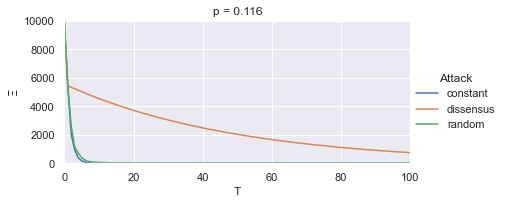

In [86]:
import pandas as pd
import seaborn as sns
stats = []
for res in results:
    p = res['exp'].p
    for t, e, cd in zip(range(res['exp'].T+1), res['exp'].errors, res['exp'].consensus_distances):
        if t > 100:
            break
        stats.append({"p_value": p, "Error": e, r"$\Xi$": cd, "T": t, "Attack": res['attack']})


plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 11
sns.set(rc={'figure.figsize': (6.75, 3)})

df = pd.DataFrame(stats)
df['p'] = df['p_value'].apply(lambda x: "{:.3f}".format(x))
g = sns.relplot(data=df, x="T", y=r"$\Xi$", row="p", kind='line', hue="Attack", height=3, aspect=2)

g.set(xlim=(0, 100))
g.set(ylim=(0, 10000))
# g.savefig("./consensus_constant_attack.pdf", bbox_inches="tight", dpi=720)

### Other consensus function

In [87]:
class ExperimentBis(object):

    def __init__(self, data_manager, graph, n, b, p, T):
        # Number of workers
        self.n = n
        # Number of Byzantine workers
        self.b = b
        self.p = p
        self.T = T

        self.data_manager = data_manager
        self.graph = graph
        self.mu0 = sum(data_manager.good_data) / len(data_manager.good_data)

        self.consensus_distances = []
        self.errors = []
    
    def consensus_node(self):
        data = self.data_manager.good_data
        mu = sum(data) / len(data)
        return [sum((i - j) ** 2 for i in data) / len(data) for j in data]

    def error(self):
        data = self.data_manager.good_data
        return sum((i - self.mu0) ** 2 for i in data) / len(data)

    def run(self):
        self.consensus_distances.append(self.consensus_node())
        self.errors.append(self.error())
        for t in range(self.T):
            new_data = []
            for i in range(self.b, self.n):
                # Aggregation on good worker i
                new_data.append(self.agg(i))

            self.data_manager.setGoodData(new_data)
            self.consensus_distances.append(self.consensus_node())
            self.errors.append(self.error())

    def agg(self, i):
        raise NotImplementedError


class SSClip(ExperimentBis):

    def agg(self, i):
        v = self.data_manager.get(i)

        delta_i = 0.33
        good_local_indices = self.graph.get_good_neighbors_index(i, include_self=False)

        tau = 0
        for j in good_local_indices:
            w = self.graph.metropolis_weight[i][j]
            d = self.data_manager.get(j)
            distance = (d - v) ** 2
            tau += w * distance
        
        if delta_i == 0:
            tau = np.inf
        else:
            tau /= delta_i
            tau = np.sqrt(tau)

        local_data = self.data_manager.getDataOn(i)
        weights = self.graph.get_neighbors_weight(i, include_self=True)
        new_data = 0
        a = []
        for index, vv, w in zip(self.graph.get_neighbors_index(i, include_self=True), local_data, weights):
            if vv == v:
                z = v
            else:
                z = v + clip(vv - v, tau)
            new_data += w * z
            a.append(f"Clip node {index} from {vv} to {z}")
        
        return new_data



In [88]:
N = 6
b = 2
data0 = [0, 0, 200, 200]

a = 1 / 3
results = []
for attacker, attack_name in [(ConstValueAttack(0, 200), "constant"), (DissensusAttack(1), "dissensus"), (RandomAttack(-1000,1000), "random")]:
    Defense, defense_name = SSClip, "SSClip"
    
    graph = Ring(n=N)
    data_manager = DataManager(data0, graph, attacker)
    p = graph.spectral_gap**2
    runner = Defense(data_manager, graph, N, b, p, 100)
    runner.run()
    results.append({"exp": runner, "attack": attack_name, "defense": defense_name})

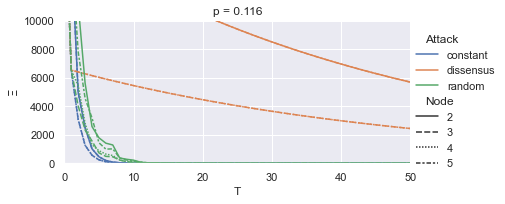

In [90]:
import pandas as pd
import seaborn as sns
stats = []
for res in results:
    for t, e, cds in zip(range(res['exp'].T+1), res['exp'].errors, res['exp'].consensus_distances):
        if t > 100:
            break
        for i in range(len(cds)):
            stats.append({"p_value": p, "Error": e, r"$\Xi$": cds[i], "T": t, "Attack": res['attack'], "Node": i+2})


plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 11
sns.set(rc={'figure.figsize': (6.75, 3)})

df = pd.DataFrame(stats)
df['p'] = df['p_value'].apply(lambda x: "{:.3f}".format(x))
g = sns.relplot(data=df, x="T", y=r"$\Xi$", row="p", kind='line', hue="Attack", style="Node", height=3, aspect=2)

g.set(xlim=(0, 50))
g.set(ylim=(0, 10000))
# g.savefig("./consensus_constant_attack.pdf", bbox_inches="tight", dpi=720)